In [2]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("asm_full_opt")
sys.path.append("initial_phase")
from phase_mask import PhaseMask
from asm_prop import ASMPropagator
from pixel_map import PixelMap
from psf_conv import PSFConv
from construct_phase_gs import PhaseGS
import config

In [2]:
asm = ASMPropagator(config)

phase = PhaseMask(
    config,
    num_masks=16,
    init="hyperbolic",
    # defocus_max=20e-6,
    X=asm.X,
    Y=asm.Y,    
    # test_orientation=True,
    trainable=False,
)

phi = phase()

In [3]:
from IPython.display import FileLink

FileLink("MNIST_psf_grid.pt")

psf_grid = torch.load("MNIST_psf_grid.pt", map_location="cpu")
ideal_psf = psf_grid
gs = PhaseGS(config, phase, asm, ideal_psf)


In [4]:
print("psf intensity sum:", ideal_psf[6].sum().item())
print("gs phase shape:", gs.phase.phi.shape)
print("g shape:", gs.g.shape)
print("sum |g|^2:", (gs.g[6].abs()**2).sum().item())

psf intensity sum: 1.0
gs phase shape: torch.Size([16, 255, 255])
g shape: torch.Size([16, 255, 255])
sum |g|^2: 1.0


In [5]:
Gz_prime = gs.psf_amp_constraint()

print("Gz shape:", gs.G.shape)
print("Gz intensity sum:", (gs.G[6].abs()**2).sum().item())

print("Gz_prime shape:", gs.G_prime.shape)
print("Gz_prime intensity sum:", (gs.G_prime[6].abs()**2).sum().item())


Gz shape: torch.Size([16, 255, 255])
Gz intensity sum: 0.9999998807907104
Gz_prime shape: torch.Size([16, 255, 255])
Gz_prime intensity sum: 1.0


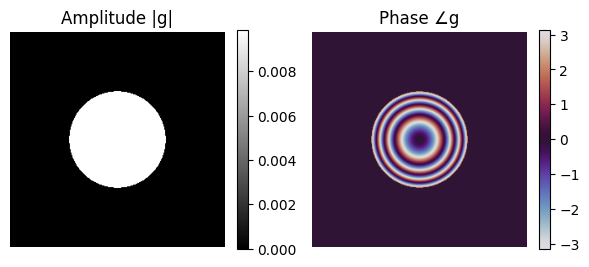

In [6]:
g0 = gs.g[6].detach().cpu()

amp = torch.abs(g0)
phase = torch.angle(g0)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

im0 = axes[0].imshow(
    amp.T,
    cmap="gray",
    origin="lower"
)
axes[0].set_title("Amplitude |g|")
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(
    phase.T,
    cmap="twilight",
    origin="lower",
    vmin=-np.pi,
    vmax=np.pi
)
axes[1].set_title("Phase ∠g")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()

Gz shape: torch.Size([16, 255, 255])
Gz_prime shape: torch.Size([16, 255, 255])


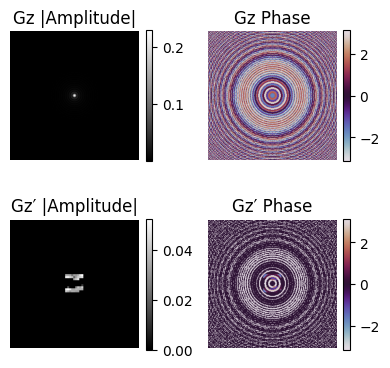

In [7]:
print("Gz shape:", gs.G.shape)
print("Gz_prime shape:", gs.G_prime.shape)

G0 = gs.G[0].detach().cpu()
Gp = gs.G_prime[0].detach().cpu()

import matplotlib.pyplot as plt
import torch
import numpy as np

# G0, Gp already defined as [N,N] complex on CPU
amp_G  = torch.abs(G0)
pha_G  = torch.angle(G0)

amp_Gp = torch.abs(Gp)
pha_Gp = torch.angle(Gp)

fig, axes = plt.subplots(2, 2, figsize=(4, 4))

# --- Gz amplitude ---
im = axes[0, 0].imshow(
    amp_G.T,
    cmap="gray",
    origin="lower"
)
axes[0, 0].set_title("Gz |Amplitude|")
axes[0, 0].axis("off")
plt.colorbar(im, ax=axes[0, 0], fraction=0.046)

# --- Gz phase ---
im = axes[0, 1].imshow(
    pha_G.T,
    cmap="twilight",
    origin="lower",
    vmin=-np.pi,
    vmax=np.pi
)
axes[0, 1].set_title("Gz Phase")
axes[0, 1].axis("off")
plt.colorbar(im, ax=axes[0, 1], fraction=0.046)

# --- Gz_prime amplitude ---
im = axes[1, 0].imshow(
    amp_Gp.T,
    cmap="gray",
    origin="lower"
)
axes[1, 0].set_title("Gz′ |Amplitude|")
axes[1, 0].axis("off")
plt.colorbar(im, ax=axes[1, 0], fraction=0.046)

# --- Gz_prime phase ---
im = axes[1, 1].imshow(
    pha_Gp.T,
    cmap="twilight",
    origin="lower",
    vmin=-np.pi,
    vmax=np.pi
)
axes[1, 1].set_title("Gz′ Phase")
axes[1, 1].axis("off")
plt.colorbar(im, ax=axes[1, 1], fraction=0.046)

plt.tight_layout()
plt.show()


In [8]:
g_iter = gs.pupil_amp_constraint()

print("g_prime shape:", gs.g_prime.shape)
print("g_prime intensity sum:", (gs.g_prime[6].abs()**2).sum().item())

print("g_iter shape:", gs.g.shape)
print("g_iter intensity sum:", (gs.g[6].abs()**2).sum().item())

g_prime shape: torch.Size([16, 255, 255])
g_prime intensity sum: 0.9953534603118896
g_iter shape: torch.Size([16, 255, 255])
g_iter intensity sum: 1.0


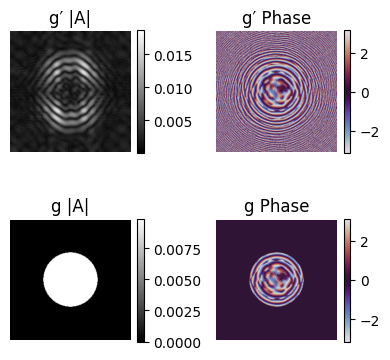

In [9]:
gP = gs.g_prime[0].detach().cpu()   # back-propagated
gI = gs.g[0].detach().cpu()         # after pupil constraint (g_iter)

amp_gP = torch.abs(gP)
pha_gP = torch.angle(gP)

amp_gI = torch.abs(gI)
pha_gI = torch.angle(gI)

fig, axes = plt.subplots(2, 2, figsize=(4, 4))

# --- g_prime amplitude ---
im = axes[0, 0].imshow(
    amp_gP.T,
    cmap="gray",
    origin="lower"
)
axes[0, 0].set_title("g′ |A|")
axes[0, 0].axis("off")
plt.colorbar(im, ax=axes[0, 0], fraction=0.046)

# --- g_prime phase ---
im = axes[0, 1].imshow(
    pha_gP.T,
    cmap="twilight",
    origin="lower",
    vmin=-np.pi,
    vmax=np.pi
)
axes[0, 1].set_title("g′ Phase")
axes[0, 1].axis("off")
plt.colorbar(im, ax=axes[0, 1], fraction=0.046)

# --- g_iter amplitude ---
im = axes[1, 0].imshow(
    amp_gI.T,
    cmap="gray",
    origin="lower"
)
axes[1, 0].set_title("g |A|")
axes[1, 0].axis("off")
plt.colorbar(im, ax=axes[1, 0], fraction=0.046)

# --- g_iter phase ---
im = axes[1, 1].imshow(
    pha_gI.T,
    cmap="twilight",
    origin="lower",
    vmin=-np.pi,
    vmax=np.pi
)
axes[1, 1].set_title("g Phase")
axes[1, 1].axis("off")
plt.colorbar(im, ax=axes[1, 1], fraction=0.046)

plt.tight_layout()
plt.show()

In [10]:
# 1. Define number of iterations
num_iters = 200

print(f"Starting GS Phase Retrieval for {num_iters} iterations...")

new_phis = gs.run_gs(num_iters=num_iters)

print("\nOptimization complete.")

with torch.no_grad():
    final_psf, Ufinal = gs.asm(phase_mask=gs.phase, normalize=True, return_field=True)



Starting GS Phase Retrieval for 200 iterations...
Iteration 20/200 - RMSE: 9.50e-05
Iteration 40/200 - RMSE: 9.03e-05
Iteration 60/200 - RMSE: 8.86e-05
Iteration 80/200 - RMSE: 8.82e-05
Iteration 100/200 - RMSE: 8.73e-05
Iteration 120/200 - RMSE: 8.70e-05
Iteration 140/200 - RMSE: 8.66e-05
Iteration 160/200 - RMSE: 8.62e-05
Iteration 180/200 - RMSE: 8.63e-05
Iteration 200/200 - RMSE: 8.59e-05

Optimization complete.


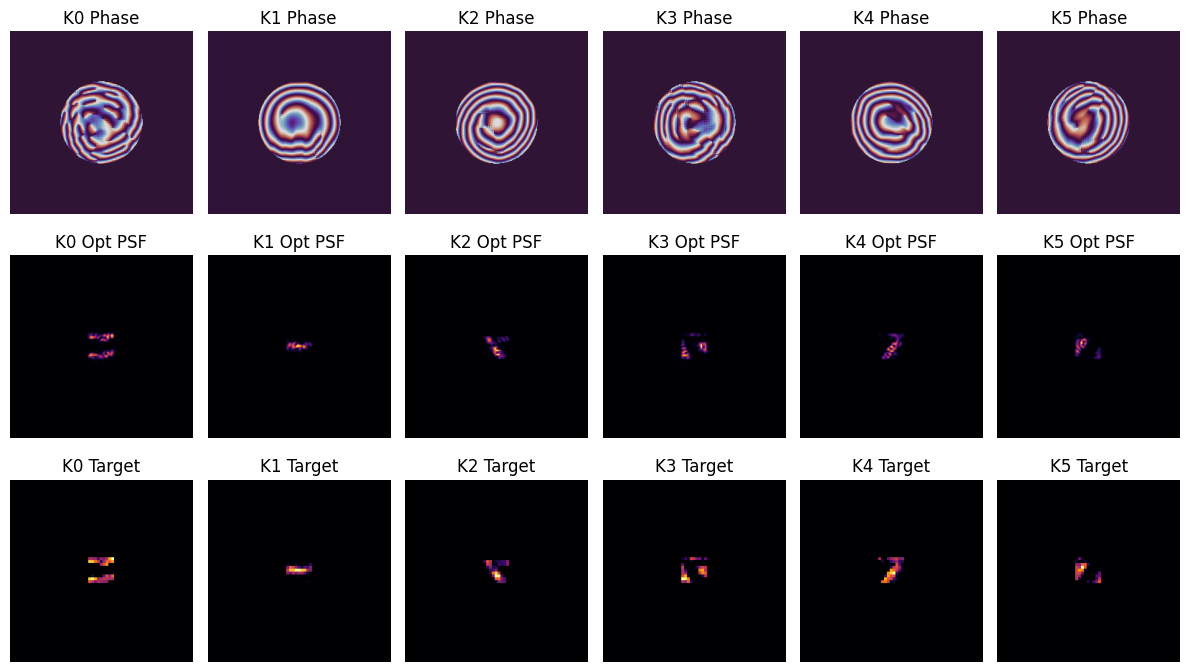

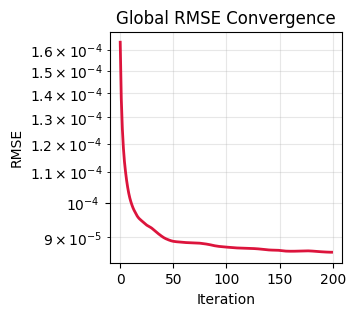

In [11]:
# --- Visualization ---
# Number of batch items (kernels) to display
num_display = 6 
fig, axes = plt.subplots(3, num_display, figsize=(12, 7))

# Calculate final PSF for the whole batch
with torch.no_grad():
    final_psf = gs.asm(phase_mask=gs.phase, normalize=True)

history = np.array(gs.error_history)

for k in range(num_display):
    # --- Row 1: Retrieved Phase ---
    ax0 = axes[0, k]
    phi_plt = gs.phase.phi[k].T.detach().cpu().numpy()
    im0 = ax0.imshow(phi_plt, cmap='twilight', origin='lower')
    ax0.set_title(f"K{k} Phase")
    ax0.axis('off')
    # if k == num_display - 1: fig.colorbar(im0, ax=ax0)

    # --- Row 2: Optimized PSF ---
    ax1 = axes[1, k]
    res_plt = final_psf[k].T.detach().cpu().numpy()
    im1 = ax1.imshow(res_plt, cmap='inferno', origin='lower')
    ax1.set_title(f"K{k} Opt PSF")
    ax1.axis('off')
    # if k == num_display - 1: fig.colorbar(im1, ax=ax1)

    # --- Row 3: Target PSF ---
    ax2 = axes[2, k]
    tgt_plt = gs.psf_ideal[k].T.detach().cpu().numpy()
    im2 = ax2.imshow(tgt_plt, cmap='inferno', origin='lower')
    ax2.set_title(f"K{k} Target")
    ax2.axis('off')
    # if k == num_display - 1: fig.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# --- Separate Plot for Convergence ---
plt.figure(figsize=(3, 3))
plt.plot(history, color='crimson', lw=2)
plt.yscale('log')
plt.title("Global RMSE Convergence")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.grid(True, which='both', alpha=0.3)
plt.show()

In [12]:
print("Ufinal shape:", Ufinal.shape)
print("Ufinal intensity sum:", (Ufinal[0].abs()**2).sum().item())

Ufinal shape: torch.Size([16, 255, 255])
Ufinal intensity sum: 1.0


In [13]:
print(len(gs.error_history))

print(gs.phase.phi.shape)
print(gs.phase.phi.dtype)

200
torch.Size([16, 255, 255])
torch.float32


In [14]:
torch.save(gs.phase.phi.cpu(), "MNIST_phase_init.pt")